In [1]:
import torch
import torch.nn as nn
import torchaudio
from pathlib import Path
import pandas as pd
import IPython.display as ipd
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
'''
Let's only use testset
'''
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz

--2022-05-17 14:19:05--  http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
Resolving download.magenta.tensorflow.org (download.magenta.tensorflow.org)... 172.217.27.48, 2404:6800:4005:808::2010
Connecting to download.magenta.tensorflow.org (download.magenta.tensorflow.org)|172.217.27.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349501546 (333M) [application/gzip]
Saving to: ‘nsynth-test.jsonwav.tar.gz’

nsynth-test.jsonwav 100%[===================>] 333.31M  7.57MB/s    in 44s     

2022-05-17 14:19:49 (7.61 MB/s) - ‘nsynth-test.jsonwav.tar.gz’ saved [349501546/349501546]



In [3]:
!tar -xf nsynth-test.jsonwav.tar.gz

In [4]:
class NSynthDataSet:
  def __init__(self, path):
    if isinstance(path, str):
      path = Path(path)
    self.path = path
    json_path = path / "examples.json"
    self.meta = pd.read_json(json_path).to_dict()
    self.file_list = list(self.path.rglob('*.wav'))
    
  def __getitem__(self, idx):
    fn = self.file_list[idx]
    audio, sr = torchaudio.load(fn)
    pitch = self.meta[fn.stem]['pitch']
    pitch_vec = torch.zeros(120)
    pitch_vec[pitch-1] = 1
    return audio, pitch_vec
  
  def __len__(self):
    return len(self.meta.keys())

dataset = NSynthDataSet(Path('nsynth-test'))

In [12]:
df = pd.read_json('nsynth-test/examples.json')
df['bass_synthetic_068-049-025']['pitch']

49

In [17]:
dataset.meta[dataset.file_list[0].stem]

{'qualities': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'pitch': 72,
 'note': 205523,
 'instrument_source_str': 'electronic',
 'velocity': 25,
 'instrument_str': 'keyboard_electronic_098',
 'instrument': 905,
 'sample_rate': 16000,
 'qualities_str': [],
 'instrument_source': 1,
 'note_str': 'keyboard_electronic_098-072-025',
 'instrument_family': 4,
 'instrument_family_str': 'keyboard'}

In [21]:
audio, pitch = dataset[2000]
ipd.Audio(audio, rate=16000)

In [22]:
audio

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

In [23]:
train_loader = DataLoader(dataset, batch_size=128, num_workers=4, shuffle=True, pin_memory=True)
# test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)
batch = next(iter(train_loader))

In [24]:
audio, pitch = batch

audio.shape, pitch.shape

(torch.Size([128, 1, 64000]), torch.Size([128, 120]))

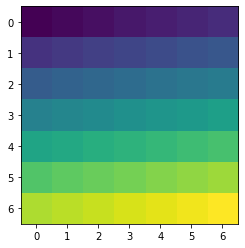

In [27]:
dummy = torch.arange(49).view(1, 7,7).float()

plt.imshow(dummy[0])

In [65]:
kernel_size = 3
padding_size= 2
stride_size = 2
conv_layer = nn.Conv2d(1, 1, kernel_size, padding=padding_size, stride=stride_size)

In [66]:
conv_output = conv_layer(dummy)

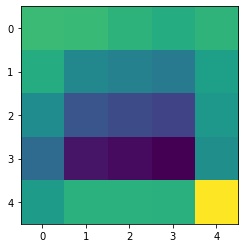

In [67]:
plt.imshow(conv_output[0].detach())

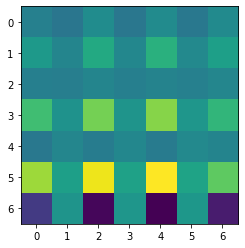

In [74]:
# kernel_size = 3
padding_size= 2
# stride_size = 2

conv_t_layer = nn.ConvTranspose2d(1,1, kernel_size, padding=padding_size, stride=stride_size)
t_output = conv_t_layer(conv_output)

plt.imshow(t_output[0].detach())

In [72]:
conv_t_layer(conv_layer(dummy)).shape, dummy.shape

(torch.Size([1, 7, 7]), torch.Size([1, 7, 7]))

In [75]:
class SpecModel(nn.Module):
  def __init__(self, n_fft, hop_length):
    super().__init__()
    self.spec_converter = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    self.db_converter = torchaudio.transforms.AmplitudeToDB(stype='power')

  def forward(self, audio_sample):
    spec = self.spec_converter(audio_sample)
    db_spec = self.db_converter(spec)
    return db_spec

class Conv2dNormPool(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
    super().__init__()
    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
    self.batch_norm = nn.BatchNorm2d(out_channels)
    self.activation = nn.ReLU()
    
  def forward(self, x):
    x = self.conv(x)
    x = self.batch_norm(x)
    x = self.activation(x)
    return x
  
class Conv2dNormTransposePool(Conv2dNormPool):
  def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
    super().__init__(in_channels, out_channels, kernel_size, padding, stride)
    self.conv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride)

  
class AutoEncoder(nn.Module):
  def __init__(self, n_fft, hop_length, hidden_size=256):
    super().__init__()
    self.spec_model = SpecModel(n_fft, hop_length)
    self.encoder = nn.Sequential()
    self.num_channels = [1] + [hidden_size // 2**i for i in reversed(range(7))]
    for i in range(6):
      self.encoder.add_module(f"conv_norm{i}", Conv2dNormPool(self.num_channels[i], self.num_channels[i+1], (4,4), 1, (2,2) ))
    self.encoder.add_module(f"final_conv",nn.Conv2d(in_channels=self.num_channels[-2], out_channels=self.num_channels[-1], kernel_size=(3,3), padding=1))
    self.final_layer = nn.Linear(hidden_size * 32, hidden_size) 
  
    self.decoder = nn.Sequential(      
        Conv2dNormTransposePool(in_channels=self.num_channels[-1]+120, out_channels=self.num_channels[-2], kernel_size=(8,4), padding=0, stride=(2,2))
    )
    for i in range(5):
      self.decoder.add_module(f"conv_norm{i}", Conv2dNormTransposePool(self.num_channels[-2-i], self.num_channels[-3-i], (4,4), 1, (2,2)))
    self.decoder.add_module("final_module",  nn.ConvTranspose2d(in_channels=self.num_channels[1], out_channels=1, kernel_size=(4,4), padding=1, stride=(2,2)),)

    
  def forward(self, x, pitch):
    spec = self.spec_model(x)
    spec = spec[:,:,:-1] # to match 512
    spec /= 80
    spec = nn.functional.pad(spec, (2,3), value=torch.min(spec))
    out = self.encoder(spec)

    latent = self.final_layer(out.view(out.shape[0], -1))
    latent = torch.cat([latent, pitch], dim=-1)
    latent = latent.view(latent.shape[0], -1, 1, 1)
    recon_spec = self.decoder(latent)
    return recon_spec, spec
  
model = AutoEncoder(1024, 256, 1024)
recon_spec, spec = model(audio, pitch)
recon_spec.shape, spec.shape

(torch.Size([128, 1, 512, 256]), torch.Size([128, 1, 512, 256]))

In [76]:
model.num_channels

[1, 16, 32, 64, 128, 256, 512, 1024]

In [100]:
model.decoder

Sequential(
  (0): Conv2dNormTransposePool(
    (conv): ConvTranspose2d(1144, 512, kernel_size=(8, 4), stride=(2, 2))
    (batch_norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (conv_norm0): Conv2dNormTransposePool(
    (conv): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (conv_norm1): Conv2dNormTransposePool(
    (conv): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (conv_norm2): Conv2dNormTransposePool(
    (conv): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activa

In [93]:
model.final_layer

Linear(in_features=32768, out_features=1024, bias=True)

In [102]:
spec = model.spec_model(audio)
spec.shape
spec = spec[:,:,:-1] # to match 512
spec /= 80
spec = nn.functional.pad(spec, (2,3), value=torch.min(spec))
out = model.encoder(spec)

out = out.reshape(out.shape[0], out.shape[1], -1)
latent = model.final_layer(out.view(out.shape[0], -1))
latent = torch.cat([latent, pitch], dim=-1)
latent = latent.unsqueeze(-1).unsqueeze(-1)

recon_spec = model.decoder(latent)
spec.shape, recon_spec.shape

(torch.Size([128, 1, 512, 256]), torch.Size([128, 1, 512, 256]))

In [99]:
latent.shape

torch.Size([128, 1144])

In [96]:
latent[0]

tensor([-0.4915, -0.0088,  0.2518,  ..., -0.1390, -0.1821, -0.2903],
       grad_fn=<SelectBackward0>)

In [84]:
spec.shape

torch.Size([128, 1, 512, 256])

In [104]:
def loss_fn(pred, target):
  return ((pred-target)**2).mean()

loss_fn(recon_spec, spec)

tensor(1.0906, grad_fn=<MeanBackward0>)

In [109]:
class WeightedSpecLoss:
  def __init__(self, fft_size=1024, sr=16000, device='cuda'):
    self.weight = torch.ones(fft_size//2).to(device)
    self.weight[:fft_size//4] = torch.linspace(10,1,fft_size//4)

  def __call__(self, pred, target):
    mse = (pred-target)**2
    mse *= self.weight[:, None]
    return mse.mean()
  
loss_calculator = WeightedSpecLoss()
loss_calculator(recon_spec.cuda(), spec.cuda())

tensor(3.2612, device='cuda:0', grad_fn=<MeanBackward0>)

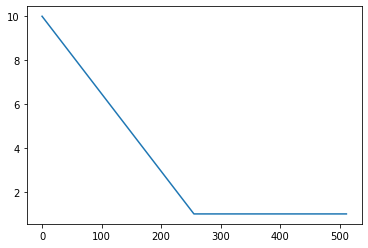

In [106]:
plt.plot(loss_calculator.weight.cpu())

In [110]:
from tqdm.auto import tqdm

num_epochs = 5
device = 'cuda'
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_loader = DataLoader(dataset, batch_size=8, num_workers=4, shuffle=True, pin_memory=True)

for epoch in tqdm(range(num_epochs)):
  for batch in train_loader:
    audio, pitch = batch
    recon_spec, spec = model(audio.to(device), pitch.to(device))
    loss = loss_calculator(recon_spec, spec)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    
    

  0%|          | 0/5 [00:00<?, ?it/s]

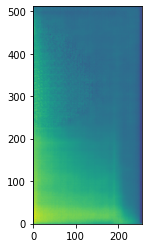

In [117]:
plt.imshow(recon_spec[4,0].detach().cpu(), origin='lower')

In [120]:
!gdown 14VsTi0tqKB7NFJQca9QpA-_envK212kn

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
Downloading...
From: https://drive.google.com/uc?id=14VsTi0tqKB7NFJQca9QpA-_envK212kn
To: /home/teo/userdata/sg-ant-5015/ant5015-2022Spring/note_autoencoder_best.pt
100%|████████████████████████████████████████| 250M/250M [00:31<00:00, 7.91MB/s]


In [121]:
pretrained_weights = torch.load('note_autoencoder_best.pt', map_location='cpu')

In [122]:
model.load_state_dict(pretrained_weights)

<All keys matched successfully>

In [123]:
test_loader = DataLoader(dataset, batch_size=64, num_workers=4,pin_memory=True)

test_batch = next(iter(test_loader))

In [132]:
model.cpu()
audio, pitch = test_batch
model.eval()
with torch.no_grad():
  recon_spec, spec = model(audio, pitch)

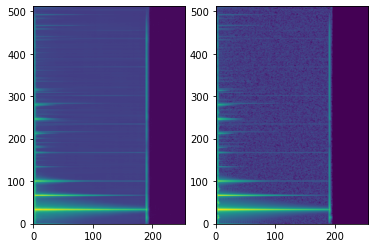

In [133]:
sample_id = 0

plt.subplot(1,2,1)
plt.imshow(recon_spec[sample_id, 0], origin='lower', aspect='auto')
plt.subplot(1,2,2)
plt.imshow(spec[sample_id, 0], origin='lower', aspect='auto')


In [ ]:
spec = model.spec_model(audio)
spec.shape
spec = spec[:,:,:-1] # to match 512
spec /= 80
spec = nn.functional.pad(spec, (2,3), value=torch.min(spec))


In [128]:
spec.shape

torch.Size([64, 1, 512, 256])

In [158]:
def network_output_to_audio(spec):
  rescaled_spec = spec * 80
  padded_spec = nn.functional.pad(rescaled_spec, (0,0, 0,1), value=-100)
  magnitude_spec = torchaudio.functional.DB_to_amplitude(padded_spec, ref=1, power=1)
  griffin_lim = torchaudio.transforms.GriffinLim(n_fft=1024, hop_length=256, n_iter=100)
  spec_recon_audio = griffin_lim(magnitude_spec)
  
  return spec_recon_audio

recon_audio = network_output_to_audio(recon_spec[10])
ipd.Audio(recon_audio, rate=16000)

In [144]:
rescaled_spec = spec * 80
padded_spec = nn.functional.pad(rescaled_spec, (0,0, 0,1), value=-100)


In [145]:
magnitude_spec = torchaudio.functional.DB_to_amplitude(padded_spec, ref=1, power=1)

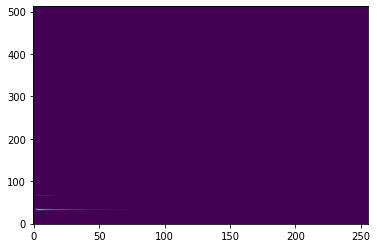

In [146]:
plt.imshow(magnitude_spec[sample_id, 0], origin='lower', aspect='auto')


In [150]:
magnitude_spec.shape

torch.Size([64, 1, 513, 256])

In [152]:
griffin_lim = torchaudio.transforms.GriffinLim(n_fft=1024, hop_length=256, n_iter=100)
spec_recon_audio = griffin_lim(magnitude_spec[0])

In [153]:
ipd.Audio(spec_recon_audio, rate=16000)

In [154]:
ipd.Audio(audio[sample_id], rate=16000)

In [147]:
??torchaudio.transforms.GriffinLim

In [160]:
audio.shape

torch.Size([64, 1, 64000])

In [176]:
sound_a = audio[10:11] 
sound_b = audio[22:23]
pitch_a = pitch[0:1]

ipd.display(ipd.Audio(sound_a.squeeze(), rate=16000))
ipd.display(ipd.Audio(sound_b.squeeze(), rate=16000))

In [195]:
sound_c = (sound_a + sound_b)/2
ipd.Audio(sound_c.squeeze(), rate=16000)

In [189]:
def get_embedding(model, x):
  spec = model.spec_model(x)
  spec = spec[:,:,:-1] # to match 512
  spec /= 80
  spec = nn.functional.pad(spec, (2,3), value=torch.min(spec))
  out = model.encoder(spec)

  latent = model.final_layer(out.view(out.shape[0], -1))
  return latent

embedding_a = get_embedding(model, sound_a)
embedding_b = get_embedding(model, sound_b)
embedding_c = get_embedding(model, sound_c)



In [178]:
embedding_a.shape, embedding_b.shape, pitch_a.shape

(torch.Size([1, 1024]), torch.Size([1, 1024]), torch.Size([1, 120]))

In [197]:
# mixed_embedding = (embedding_a + embedding_b)/2
# mixed_embedding = (embedding_a * 0.7 + embedding_b *0.3)
# mixed_embedding = embedding_c
mixed_embedding = embedding_a

In [205]:
pitch_b = torch.zeros(1, 120)
pitch_b[0, 83] = 1

In [210]:
def decoding(model, latent, pitch):
  latent = torch.cat([latent, pitch], dim=-1)
  latent = latent.view(latent.shape[0], -1, 1, 1)
  recon_spec = model.decoder(latent)
  return recon_spec

mixed_spec = decoding(model, mixed_embedding, pitch_b)

In [211]:
mixed_audio = network_output_to_audio(mixed_spec)
ipd.Audio(mixed_audio.detach().squeeze(), rate=16000)

In [219]:
pitch_embedding_dim = 512
# pitch_embedder = nn.Embedding(120, pitch_embedding_dim)
pitch_embedder = nn.Linear(120, pitch_embedding_dim, bias=False)
pitch_embedding = pitch_embedder(pitch_a)

cat_embedding = torch.cat([mixed_embedding, pitch_embedding], dim=-1)
# cat_embedding = torch.cat([mixed_embedding, pitch_a], dim=-1)

cat_embedding.shape

torch.Size([1, 1536])

In [218]:
pitch_a

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [217]:
model.decoder[0]

Conv2dNormTransposePool(
  (conv): ConvTranspose2d(1144, 512, kernel_size=(8, 4), stride=(2, 2))
  (batch_norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)